### Following improvements made
1. Sampling of vs: instead of `v ~ normal(0,1)`, we put a prior on the radius of the unit vector
`sqrt(dot_self(v)) ~ gamma(100,100)` and correct for the Jacobian `-log(r)*(D-q)` for each $ v \in \mathbb{S}^{q-1}$.   
   There are some issues to sample from a unit sphere in Stan if the dimension of the vector is too low. For more details, see [Stan Forum](https://discourse.mc-stan.org/t/divergence-treedepth-issues-with-unit-vector/8059/3).   
2. Initialize the parameters in HMC in Stan with the classical PCA solution (leads to faster convergence). 

In [1]:
import warnings; warnings.simplefilter('ignore')

In [2]:
import matplotlib.pyplot as plt 
import numpy as np
import pystan
from sklearn import datasets
from py_stan_code.helper_functions import StanModel_cache # saves compilation time

# parameter initialization with pca result
from py_stan_code.helper_functions import get_vs_stan_inp, pca_solution

%matplotlib inline 

<h3>Compile Stan Code</h3>

In [3]:
def stan_model(file):
    with open(file) as f:
        stan_code = f.read()
    return StanModel_cache(model_code=stan_code)


file = "py_stan_code/ppca_house_improved.stan"
file2 = "py_stan_code/ppca.stan"

model_house = stan_model(file)    # householder parameterization
model_standard = stan_model(file2)# standard parameterization by W

Using cached StanModel
Using cached StanModel


<h3>Define helper functions</h3>

In [4]:
c = 5*['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orangered', 'grey', 'darkred', 
     'lawngreen', 'indigo', 'deeppink', 'deepskyblue', 'goldenrod']
def plt_info(ax, x=None, y=None, legend=None, title=None):
    if x is not None: ax.set_xlabel(x)
    if y is not None: ax.set_ylabel(y)
    if legend is not None: ax.legend()
    if title is not None: ax.set_title(title)

        
def plot(W_house, W_standard, figsize=(6,6)):
    c1, c2 = 0, 1   #Q_fit-1, Q_fit-2
    #show N_show random columns of W 
    D_show = 10
    ds = np.arange(0, W_house.shape[1])
    np.random.shuffle(ds)
    ds = ds[:D_show]

    fig = plt.figure(figsize=figsize)

    ax = fig.add_subplot(111)
    for i,d in enumerate(ds):
        ax.scatter(W_house[:,d,c1], W_house[:,d,c2], alpha=0.03, c=c[i], rasterized=True)
        ax.scatter(W_standard[:,d,c1], W_standard[:,d,c2], alpha=0.02, c=c[i], rasterized=True)
    plt_info(ax, '$W_1$', '$W_2$')
    #ax.scatter(W_pca[ds,c1], W_pca[ds,c2], marker='o', s=70,  c='black', alpha=0.7)

    return fig


def timer(f):
    """decorator to measure run time of a function f"""
    from time import time
    def wrapper(*args, **kwargs):
        start = time()
        rv = f(*args, **kwargs)
        dtime = time() - start
        dtime /= 60
        print("timer [min]: {}".format(dtime))
        return rv
    return wrapper


def stability_analysis(samples):
    import py_stan_code.stan_utility as su
    su.check_div(samples)
    su.check_treedepth(samples)
    su.check_n_eff(samples)
    su.check_energy(samples)


@timer
def run_stan(model, Y, N, D, Q, chains=4, iterations=2000, init="random"):
    data_dict = {'N':N, 'D':D, 'Q':Q, 'Y':Y}
    samples = model.sampling(data_dict, chains=chains, iter=iterations,
                            init=init)
    return samples
    
    
def fit(Y, Q, model, chains=4, iterations=2000):
    N, D = Y.shape
    
    #get PCA solution
    U_pca, sigma_pca = pca_solution(Y, Q)
    #W_pca = np.dot(U_pca,np.diag(sigma_pca))
    
    #get the vs by transforming U_pca to identity by Hs
    vs_stan_inp = get_vs_stan_inp(U_pca, D, Q)
    
    def init_fun():
        """Initialize with PCA solution"""
        return dict(
            v = vs_stan_inp,
            sigma = sigma_pca[::-1],   #ordering of stan is different
            mu = list(np.zeros(shape=D)),
            sigma_noise = 0.01
        )
    
    samples = run_stan(model, Y, N, D, Q, chains=chains, 
                       iterations=iterations, init=init_fun)
    return samples

### run analysis on different datasets

(150, 4)
running householder parameterization
timer [min]: 0.15242083072662355
running standard parameterization
timer [min]: 0.7595905542373658

Analysis householder parameterization
0.0 of 4000 iterations ended with a divergence (0.0%)
0 of 4000 iterations saturated the maximum tree depth of 10 (0.0%)
n_eff / iter looks reasonable for all parameters
E-BFMI indicated no pathological behavior

Analysis standard parameterization
0.0 of 4000 iterations ended with a divergence (0.0%)
0 of 4000 iterations saturated the maximum tree depth of 10 (0.0%)
n_eff / iter looks reasonable for all parameters
E-BFMI indicated no pathological behavior


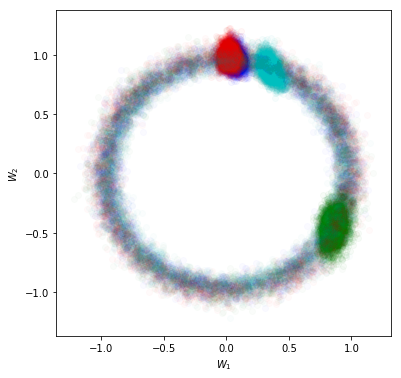

_________________________________________

(442, 10)
running householder parameterization
timer [min]: 8.906165492534637
running standard parameterization
timer [min]: 2.4365479350090027

Analysis householder parameterization
0.0 of 4000 iterations ended with a divergence (0.0%)
0 of 4000 iterations saturated the maximum tree depth of 10 (0.0%)
n_eff / iter looks reasonable for all parameters
E-BFMI indicated no pathological behavior

Analysis standard parameterization
0.0 of 4000 iterations ended with a divergence (0.0%)
0 of 4000 iterations saturated the maximum tree depth of 10 (0.0%)
n_eff / iter looks reasonable for all parameters
E-BFMI indicated no pathological behavior


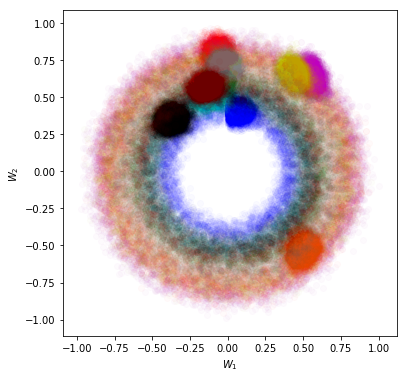

_________________________________________

(178, 13)
running householder parameterization
timer [min]: 0.36486395994822185
running standard parameterization
timer [min]: 1.2057844003041585

Analysis householder parameterization
0.0 of 4000 iterations ended with a divergence (0.0%)
0 of 4000 iterations saturated the maximum tree depth of 10 (0.0%)
n_eff / iter looks reasonable for all parameters
E-BFMI indicated no pathological behavior

Analysis standard parameterization
0.0 of 4000 iterations ended with a divergence (0.0%)
0 of 4000 iterations saturated the maximum tree depth of 10 (0.0%)
n_eff / iter looks reasonable for all parameters
E-BFMI indicated no pathological behavior


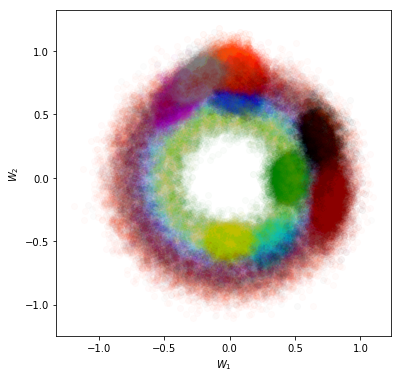

_________________________________________

(569, 30)
running householder parameterization
timer [min]: 9.418961568673451
running standard parameterization
timer [min]: 25.60258107185364

Analysis householder parameterization
0.0 of 4000 iterations ended with a divergence (0.0%)
0 of 4000 iterations saturated the maximum tree depth of 10 (0.0%)
n_eff / iter looks reasonable for all parameters
E-BFMI indicated no pathological behavior

Analysis standard parameterization
0.0 of 4000 iterations ended with a divergence (0.0%)
0 of 4000 iterations saturated the maximum tree depth of 10 (0.0%)
n_eff / iter looks reasonable for all parameters
E-BFMI indicated no pathological behavior


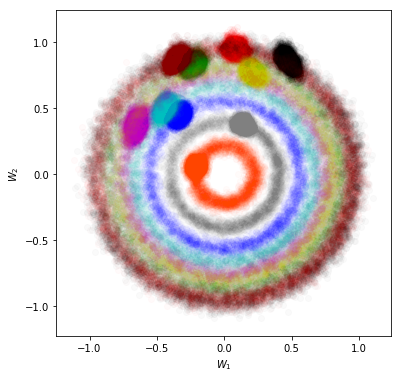

_________________________________________



In [5]:
#get datasets
Ys = [datasets.load_iris()["data"],
        datasets.load_diabetes()["data"],
        datasets.load_wine()["data"],
        datasets.load_breast_cancer()["data"],]

#set parameter
Q_fit = 2
params = {"chains":4, "iterations":2000}

#run analysis
for Y in Ys:
    print(Y.shape)
    Y = (Y - Y.mean(axis=0))/Y.std(axis=0) #normalize data
    
    print("running householder parameterization")
    samples_house = fit(Y, Q_fit, model_house, **params)
    print("running standard parameterization")
    samples_standard = fit(Y, Q_fit, model_standard, **params)
    
    print("\nAnalysis householder parameterization")
    stability_analysis(samples_house)
    print("\nAnalysis standard parameterization")
    stability_analysis(samples_standard)
    
    W_house = samples_house.extract(['W'])['W']
    W_standard = samples_standard.extract(['W'])['W']
    
    plot(W_house, W_standard)
    plt.show()
    print("_________________________________________\n")